# Electrode Localization

Change into the parent directory to find the `dj_local_conf.json` file.

In [ ]:
# change to the upper level folder to detect dj_local_conf.json
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [ ]:
# We'll be working with long tables, so we'll make visualization easier with a limit
import datajoint as dj
dj.config["display.limit"] = 10

## Coordinate Framework

The Allen Institute hosts [brain atlases](http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017) and [ontology trees](https://community.brain-map.org/t/allen-mouse-ccf-accessing-and-using-related-data-and-tools/359) that we'll use in the next section. The `localization.py` script assumes this is your first atlas, and that you'll use the 100μm resolution. For finer resolutions, edit `voxel_resolution` in `localization.py`. Higher resolution `nrrd` files are quite large when loaded. Depending on the python environment, the terminal may be killed when loading so much information into memory. To load multiple atlases, increment `ccf_id` for each unique atlas.

To run this pipeline ...
1. Download the 100μm `nrrd` and `csv` files from the links above.
2. Move these files to your ephys root directory.

Next, we'll populate the coordinate framework schema simply by loading it. Because we are loading the whole brain volume, this may take 25 minutes or more.

In [2]:
from workflow_array_ephys.localization import coordinate_framework as ccf

Connecting cbroz@dss-db.datajoint.io:3306


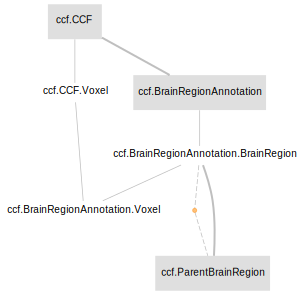

In [3]:
dj.Diagram(ccf)

Now, to explore the data we just loaded.

In [3]:
ccf.BrainRegionAnnotation.BrainRegion()

"ccf_id CCF ID, a.k.a atlas ID",acronym CHARACTER SET utf8 COLLATE utf8_bin,region_name,region_id,color_code hexcode of the color code of this region
0,6b,Layer 6b isocortex,16,8ADA87
0,a_a_a,Anterior amygdalar area,23,80C0E2
0,a_c_a,Anterior cingulate area,31,40A666
0,a_c_a1,Anterior cingulate area layer 1,572,40A666
0,a_c_a2/3,Anterior cingulate area layer 2/3,1053,40A666
0,a_c_a5,Anterior cingulate area layer 5,739,40A666
0,a_c_a6a,Anterior cingulate area layer 6a,179,40A666
0,a_c_a6b,Anterior cingulate area layer 6b,227,40A666
0,a_c_ad,Anterior cingulate area dorsal part,39,40A666
0,a_c_ad1,Anterior cingulate area dorsal part layer 1,935,40A666


The acronyms listed in the DataJoint table differ slightly from the CCF standard by substituting case-sensitive differences with [snake case](https://en.wikipedia.org/wiki/Snake_case). To lookup the snake case equivalent, use the `retrieve_acronym` function.

In [4]:
central_thalamus = ccf.BrainRegionAnnotation.retrieve_acronym("CM")
cranial_nerves = ccf.BrainRegionAnnotation.retrieve_acronym("cm")
print(f"CM: {central_thalamus}\ncm: {cranial_nerves}")

CM: c_m
cm: cm


If your work requires the case-sensitive columns please get in touch with the DataJoint team via [StackOverflow](https://stackoverflow.com/questions/tagged/datajoint).

For this demo, let's look at the dimensions of the central thalamus. To look at other regions, open the CSV you downloaded and search for your desired region.

In [10]:
cm_voxels = ccf.BrainRegionAnnotation.Voxel() & f'acronym="{central_thalamus}"'
cm_voxels

"ccf_id CCF ID, a.k.a atlas ID",acronym CHARACTER SET utf8 COLLATE utf8_bin,x (um) Anterior-to-Posterior (AP axis),y (um) Superior-to-Inferior (DV axis),z (um) Left-to-Right (ML axis)
0,c_m,100,3300,4900
0,c_m,100,3300,5000
0,c_m,100,3300,5100
0,c_m,100,3300,5200
0,c_m,100,3300,5300
0,c_m,100,3300,6100
0,c_m,100,3300,6200
0,c_m,100,3300,6300
0,c_m,100,3300,6400
0,c_m,100,3300,6500


In [17]:
cm_x, cm_y, cm_z = cm_voxels.fetch("x", "y", "z")
print(
    f"The central thalamus extends from \n\tx = {min(cm_x)}  to x = {max(cm_x)}\n\t"
    + f"y = {min(cm_y)} to y = {max(cm_y)}\n\tz = {min(cm_z)} to z = {max(cm_z)}"
)

The central thalamus extends from 
	x = 100  to x = 8400
	y = 2600 to y = 7500
	z = 1700 to z = 9700


## Electrode Localization

If you have `channel_location` json files for your data, you can look at the position and regions associated with each electrode. Here, we've added an example file to our pre-existing `subject6` for demonstration purposes.

In [4]:
from workflow_array_ephys.localization import coordinate_framework as ccf
from workflow_array_ephys.localization import electrode_localization as eloc

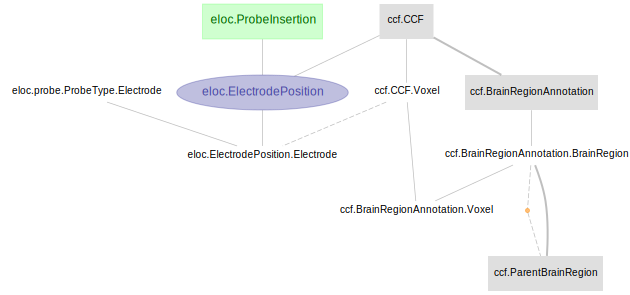

In [9]:
(dj.Diagram(eloc) + dj.Diagram(ccf) - 1)

Because the probe may not be fully inserted, there will be some electrode positions that occur outside the brain. We register these instances with an `IntegrityError` warning because we're trying to register a coordinate position with no corresponding location in the `ccf.CCF.Voxel` table. We can silence these warnings by setting the log level before running `populate()` on the `ElectrodePosition` table.

In [ ]:
import logging

In [3]:
logging.getLogger().setLevel(logging.ERROR)  # or logging.INFO

In [ ]:
eloc.ElectrodePosition.populate()

By calling the `ElectrodePosition` table, we can see the keys the `populate()` method has already processed.

In [6]:
eloc.ElectrodePosition()

subject,session_datetime,insertion_number,"ccf_id CCF ID, a.k.a atlas ID"
subject5,2018-07-03 20:32:28,1,0
subject5,2018-07-03 20:32:28,2,0
subject6,2021-01-15 11:16:38,0,0


Let's focus on `subject5`, insertion `1`.

In [ ]:
from workflow_array_ephys.pipeline import ephys

In [8]:
key = (ephys.EphysRecording & 'subject="subject5"' & "insertion_number=1").fetch1("KEY")
len(eloc.ElectrodePosition.Electrode & key)

373

With a resolution of 100μm, adjacent electrodes will very likely be in the same region. Let's look at every 38th electrode to sample 10 across the probe.

If you're interested in more electrodes, decrease the number next to the `%` modulo operator.

In [13]:
electrode_coordinates = (
    eloc.ElectrodePosition.Electrode & "electrode%38=0" & key
).fetch("electrode", "x", "y", "z", as_dict=True)
for e in electrode_coordinates:
    x, y, z = [e[k] for k in ("x", "y", "z")]
    acronym = (ccf.BrainRegionAnnotation.Voxel & f"x={x}" & f"y={y}" & f"z={z}").fetch1(
        "acronym"
    )
    e["region"] = (
        ccf.BrainRegionAnnotation.BrainRegion & f'acronym="{acronym}"'
    ).fetch1("region_name")
    print("Electrode {electrode} (x={x}, y={y}, z={z}) is in {region}".format(**e))

Electrode 0 (x=11900, y=6300, z=6900) is in Primary auditory area
Electrode 38 (x=11900, y=6300, z=6500) is in Primary auditory area
Electrode 76 (x=11800, y=6300, z=6100) is in Declive (VI) Purkinje layer
Electrode 114 (x=11700, y=6400, z=5600) is in Lobules IV-V molecular layer
Electrode 152 (x=11700, y=6400, z=5200) is in Declive (VI) Purkinje layer
Electrode 190 (x=11600, y=6500, z=4700) is in Primary auditory area
Electrode 228 (x=11600, y=6500, z=4300) is in Granular lamina of the cochlear nuclei
Electrode 266 (x=11600, y=6600, z=3900) is in Cuneiform nucleus
Electrode 304 (x=11600, y=6600, z=3500) is in Lateral hypothalamic area
Electrode 342 (x=11600, y=6700, z=3100) is in root
Electrode 380 (x=11600, y=6700, z=2800) is in root


In [7]:
eloc.ElectrodePosition.Electrode()

subject,session_datetime,insertion_number,"ccf_id CCF ID, a.k.a atlas ID",probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0",x (um) Anterior-to-Posterior (AP axis),y (um) Superior-to-Inferior (DV axis),z (um) Left-to-Right (ML axis)
subject5,2018-07-03 20:32:28,2,0,neuropixels 1.0 - 3A,206,11000,4600,4600
subject5,2018-07-03 20:32:28,2,0,neuropixels 1.0 - 3A,207,11000,4600,4600
subject6,2021-01-15 11:16:38,0,0,neuropixels 1.0 - 3B,206,11000,4600,4600
subject6,2021-01-15 11:16:38,0,0,neuropixels 1.0 - 3B,207,11000,4600,4600
subject5,2018-07-03 20:32:28,2,0,neuropixels 1.0 - 3A,196,11000,4600,4700
subject5,2018-07-03 20:32:28,2,0,neuropixels 1.0 - 3A,197,11000,4600,4700
subject5,2018-07-03 20:32:28,2,0,neuropixels 1.0 - 3A,198,11000,4600,4700
subject5,2018-07-03 20:32:28,2,0,neuropixels 1.0 - 3A,199,11000,4600,4700
subject5,2018-07-03 20:32:28,2,0,neuropixels 1.0 - 3A,200,11000,4600,4700
subject5,2018-07-03 20:32:28,2,0,neuropixels 1.0 - 3A,201,11000,4600,4700
